<a href="https://colab.research.google.com/github/EBH2002/AppliedMachineLearning/blob/main/prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESHA BHATTACHARYA(MDS202324)

In [ ]:
# @title Importing required libraries

import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AML_ASSIGNMENT_1/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])


In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

In [ ]:
df.isnull().sum()

,0
label,0
message,0


In [ ]:
df.duplicated().sum()

403

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5169 non-null   object
 1   message  5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [ ]:
df['message_length'] = df['message'].apply(len)
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
df.groupby('label').describe().T

label                         ham        spam
message_length count  4516.000000  653.000000
               mean     70.905890  137.704441
               std      56.715046   29.821348
               min       2.000000   13.000000
               25%      34.000000  132.000000
               50%      53.000000  148.000000
               75%      91.000000  157.000000
               max     910.000000  223.000000

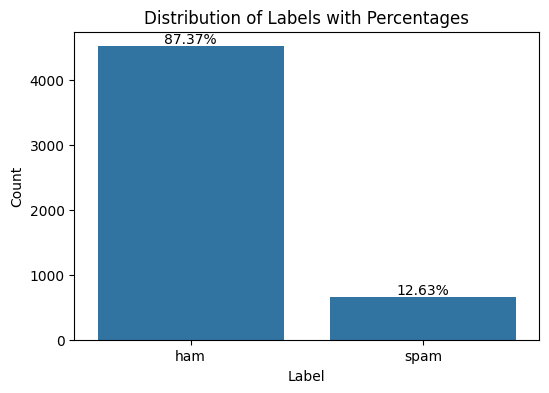

In [ ]:
# @title Data Visualisation
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='label')

total = len(df['label'])
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels with Percentages')

plt.show()

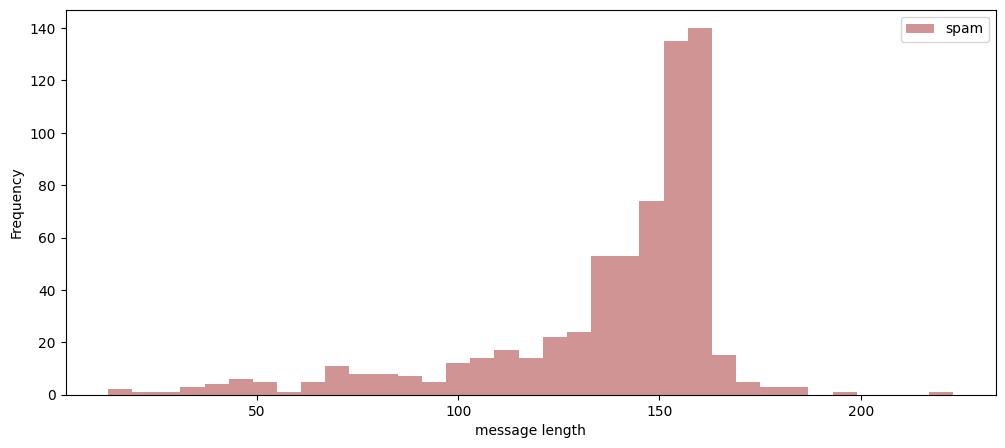

In [ ]:
# @title Distribution of message lengths of spam messages
plt.figure(figsize=(12,5))
df[df['label']=='spam']['message_length'].plot(bins=35,kind='hist',color='brown',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

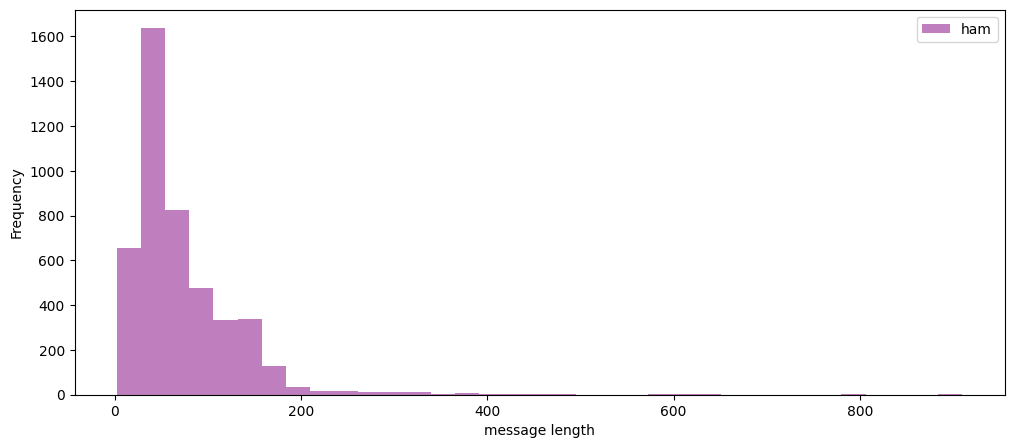

In [ ]:
# @title Distribution of message lengths of ham messages
plt.figure(figsize=(12,5))
df[df['label']=='ham']['message_length'].plot(bins=35,kind='hist',color='purple',label='ham',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

Average length of spam messages is greater than that of ham messages. Also, the message length of spam is negatively skewed and ham's is positively skewed indicating that spam messages are generally longer than spam messages

In [ ]:
#converting labels into numerical values
df.label.replace("ham",0,inplace = True)
df.label.replace("spam",1,inplace = True)

df['label'].value_counts()

,count
label,
0,4516
1,653


In [ ]:
#saving a copy
df_copy = df.copy()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
# Removing the HTML Tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

def preprocess_text(text):
    text = strip_html(text)
    text = remove_square_brackets(text)
    text= remove_url(text)
    text = remove_stopwords(text)
    return text

In [ ]:
df['p_message']=df['message'].apply(preprocess_text)
df.head()

,label,message,message_length,p_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though


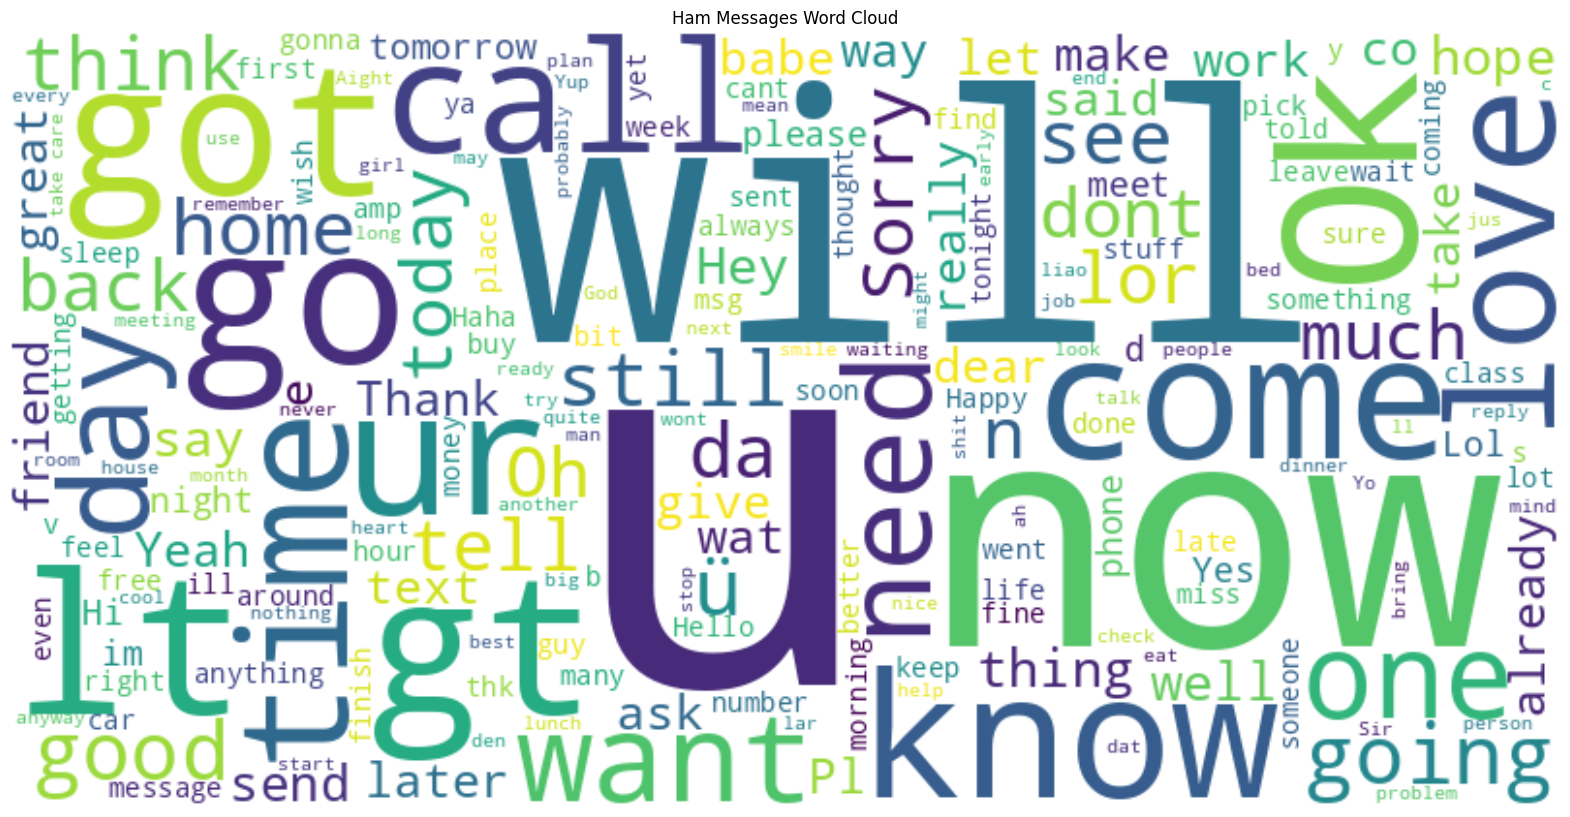

-------------------------------------------------------------------------------------------------------------------------------


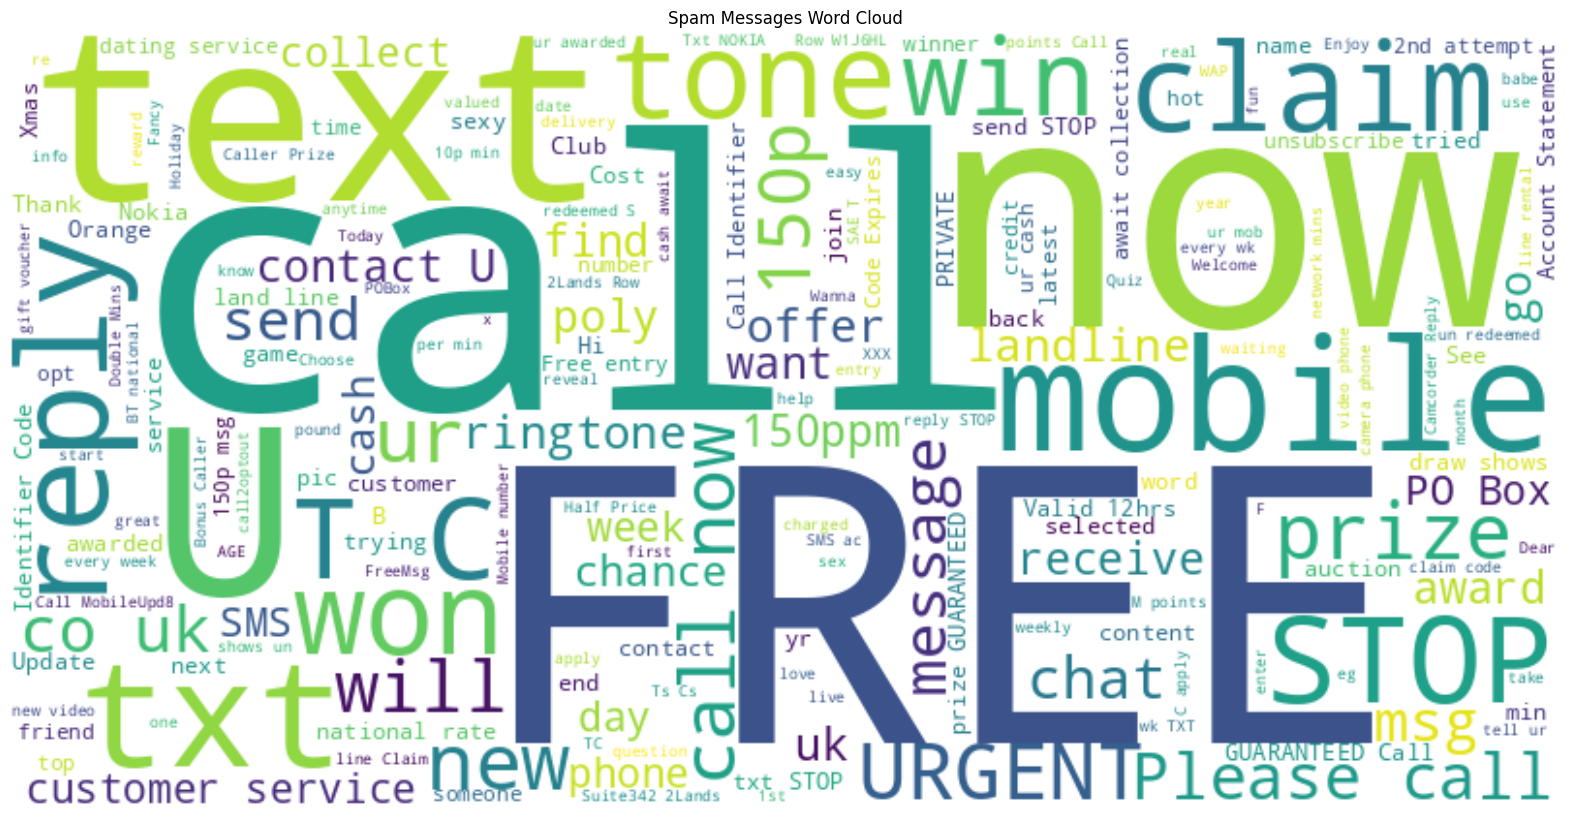

In [ ]:
# @title Word cloud of ham and spam messages

# Separati the messages based on categories
ham_messages = df[df['label'] == 0]['message']
spam_messages = df[df['label'] == 1]['message']

# Combining ham messages into a single string
ham_text = " ".join(ham_messages)

# Combining spam messages into a single string
spam_text = " ".join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(20, 20))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')
plt.show()

print('-'*127)

plt.figure(figsize=(20, 20))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.show()


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
snowball_stemmer = SnowballStemmer('english')

preprocessed_messages = []

for _, row in df.iterrows():
    review = re.sub('[^a-zA-Z]', ' ', row['message'])
    review = review.lower() #lowercasing
    tokens = word_tokenize(review) #tokenizing
    tokens = [snowball_stemmer.stem(word) for word in tokens if not word in stopwords.words('english')] #stemming
    preprocessed_review = ' '.join(tokens)
    preprocessed_messages.append(preprocessed_review)

df['p_message'] = df['p_message']

df.head()

,label,message,message_length,p_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though


In [ ]:
df['p_message_length'] = df['p_message'].apply(len)

df.head()

,label,message,message_length,p_message,p_message_length
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...,59
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u,15
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...,78
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already,27
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though,34


In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.3, random_state=42, stratify=train_val_df['label'])

tf = TfidfVectorizer()

# Fitting the vectorizer on the training data and transform train, validation, and test sets
X_train = tf.fit_transform(train_df['p_message'])
X_val = tf.transform(val_df['p_message'])
X_test = tf.transform(test_df['p_message'])

# Adding labels to the splits
train_data = pd.DataFrame(X_train.toarray())
train_data['label'] = train_df['label'].values

validation_data = pd.DataFrame(X_val.toarray())
validation_data['label'] = val_df['label'].values

test_data = pd.DataFrame(X_test.toarray())
test_data['label'] = test_df['label'].values


In [ ]:
drive_folder = '/content/drive/MyDrive/AML_ASSIGNMENT_1/'

train_data.to_csv(drive_folder + 'train.csv', index=False)
validation_data.to_csv(drive_folder + 'validation.csv', index=False)
test_data.to_csv(drive_folder + 'test.csv', index=False)

In [ ]:
train_data.shape

(2894, 4293)

In [ ]:
test_data.shape

(1034, 4293)

In [ ]:
validation_data.shape

(1241, 4293)